# Population asymmetry and packed precincts

How much gerrymandering is "unintentional gerrymandering"? Below, we'll look at histograms showing the population of people in a state's precincts, binned by the Republican vote share in those precincts. Before we do, a couple important notes:

- *What does "unintentional gerrymandering" mean?* 
Roughly, it's the idea that results that seem unfair can actually be, at least in part, a consequence of how people choose to distribute themselves and not malicious gerrymandering. 


- *Oh, so it's the idea that Democrats pack themselves into cities* 
Not quite. Packing-- when a district is crammed full of voters of a particular party-- isn't an area thing. If we had a district spread out over a large rural area where the dispersed voters happened to vote 100% Republican, such a district would be just as packed as a small urban district that votes 100% Democrat. A curious property of the data, though, is that there aren't really areas where the vote share is essentially 100% Republican, even in red states, though there are areas that are nearly 100% Democrat.


- *How does this change the way elections shake out?* 
It depends on the state, and even then, the picture's not super clear. The fact that there are places that are nearly 100% Democrat but not, symmetrically, places that are 100% Republican, means that in areas at these partisan extremes, Democrats "waste" more votes than Republicans. As you change the tolerance for what counts as a partisan extreme (e.g. precincts that were 20% or less Republican vs precincts that were 80% or more Republican), the story with the asymmetry can start to change.



In [142]:
# Helper functions to pull/plot precincts, their populations, 
# and the percent of Republican voteshare in the 2016 Presidential election

%run utilities

import shapefile
import matplotlib.pyplot as plt
import numpy as np

bar_plot_color = [0.36078431372549,0.682352941176471,0.611764705882353]
dt = 0.01  # Bin size for precinct vote shares
             

def get_precinct_population_and_voting_data(state):
        
    if state == "MD":
        data = shapefile.Reader('data/MD-shapefiles/MD_precincts_abs.shp')  # From: https://github.com/mggg-states/GA-shapefiles
        # republican_index = 28  # PRES12
        # democrat_index = 29    # PRES12
        republican_index = 48    # PRES16
        democrat_index = 49      # PRES16

    if state == "GA":
        data = shapefile.Reader('data/GA-shapefiles/GA_precincts16.shp')  # From https://github.com/mggg-states/GA-shapefiles
        republican_index = 8     # PRES16
        democrat_index = 7       # PRES16

    if state == "TX":
        data = shapefile.Reader('data/TX_vtds/TX_vtds.shp')  # From https://github.com/mggg-states/TX-shapefiles
        # republican_index = 16  # PRES12 
        # democrat_index = 17    # PRES12
        republican_index = 29    # PRES16 
        democrat_index = 28      # PRES16

    if state == "MA":
        data = shapefile.Reader('data/MA-shapefiles/MA_precincts_12_16/MA_precincts12_16.shp')  # From https://github.com/mggg-states/MA-shapefiles
        republican_index = 16
        democrat_index = 15
    
    if state == "PA":
        data = shapefile.Reader('data/PA-shapefiles/PA.shp')  # From https://github.com/mggg-states/PA-shapefiles
        # republican_index = 54  # SEN16
        # democrat_index = 53    # SEN16
        republican_index = 52    # PRES16
        democrat_index = 50      # PRES16


    
    fields = data.fields[1:] 
    field_names = [field[0] for field in fields] 
    print(fields[republican_index])
    print(fields[democrat_index])
    # for i in range(len(field_names)):
    # print(str(i) + " " + field_names[i])
        
    populations_and_republican_vote_shares = []
    for record in data.shapeRecords():
        dem_and_rep_votes = int(record.record[republican_index]) + int(record.record[democrat_index])
        if dem_and_rep_votes > 0:
            precinct = [dem_and_rep_votes, int(record.record[republican_index])/dem_and_rep_votes]
            populations_and_republican_vote_shares.append(precinct)

    populations_and_republican_vote_shares = np.array(populations_and_republican_vote_shares)
    return populations_and_republican_vote_shares


def get_histogram(state):
    populations_and_republican_vote_shares = get_precinct_population_and_voting_data(state)
    histogram_bins = np.arange(0,1 + dt,dt)

    total_population = []

    for i in range(0,len(histogram_bins) - 1):
        lower_bound = histogram_bins[i]
        upper_bound = histogram_bins[i + 1]
        indices_in_range = np.argwhere((populations_and_republican_vote_shares[:,1] >= lower_bound) & (populations_and_republican_vote_shares[:,1] < upper_bound)).flatten()
        total_population.append(np.sum(populations_and_republican_vote_shares[indices_in_range,0]))


    total_population = np.array(total_population)
    histogram_centers = np.arange(0 + dt/2, 1 + dt/2, dt)
    return histogram_centers, total_population

def get_population_in_range(lower_bound, upper_bound, histogram_centers, total_population):
    population_in_range = 0
    
    for i in range(len(histogram_centers)):
        vote_share = histogram_centers[i]
        if vote_share >= lower_bound and vote_share < upper_bound:
            population_in_range = population_in_range + total_population[i]
    return population_in_range

def get_population_in_range_for_state(state,lower_bound,upper_bound):
    histogram_centers, total_population = get_histogram(state)
    population_in_range = get_population_in_range(lower_bound, upper_bound, histogram_centers, total_population)
    return population_in_range
    
def plot_precinct_population_histogram(state):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    histogram_centers, total_population = get_histogram(state)    
    plt.bar(histogram_centers,total_population, dt,color=bar_plot_color)
    
    ax.text(0,1.05*np.amax(total_population),state,fontsize=big_text_size,fontname=font_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Republican vote share in precincts", fontname=font_name, fontsize=font_size)
    ax.set_ylabel("Voting population in precincts", fontname=font_name, fontsize=font_size)

def plot_histogram_row(states):
    
    N = len(states)
    scalar = 1.05
    fig, axs = plt.subplots(1, N, sharex=True,figsize=(10,2.5),dpi=500)  
    fig.tight_layout()
    for i in range(N):
        ax = axs[i]
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        histogram_centers, total_population = get_histogram(states[i])    

        ax.bar(histogram_centers,total_population, dt,color=bar_plot_color)
        
        ax.plot([0.15, 0.15],[0, scalar*np.amax(total_population)], '--', color=grid_color)
        ax.plot([0.85, 0.85],[0, scalar*np.amax(total_population)], '--', color=grid_color)

        ax.text(0,scalar*np.amax(total_population),states[i],fontsize=15,fontname=font_name)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.ticklabel_format(useOffset=False, style='plain')
        ax.set_xlabel("Republican vote share in precincts", fontname=font_name, fontsize=8)
        
        if i == 0:
            ax.set_ylabel("Voting population in precincts", fontname=font_name, fontsize=8)
            

['T16PRESR', 'N', 19, 15]
['T16PRESD', 'N', 19, 15]
['T16PRESR', 'N', 19, 15]
['T16PRESD', 'N', 19, 15]


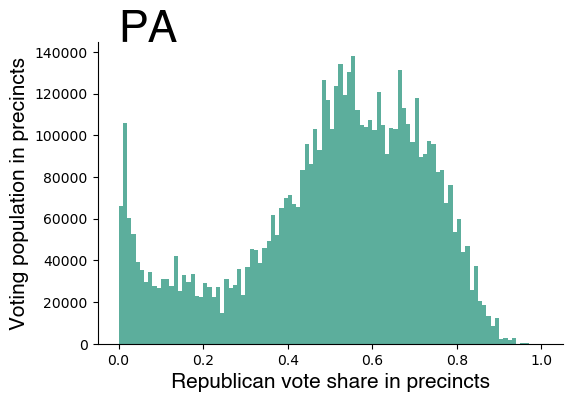

In [150]:
# You can use this cell to plot individual population histograms for the states we have precinct data
# PA, TX, MD, GA, MA

state = "PA"
plot_precinct_population_histogram(state)

population_and_vote_share = get_precinct_population_and_voting_data(state)

In [144]:
population = population_and_vote_share[:,0]
vote_share = population_and_vote_share[:,1]

republican_precinct_vote_shares = vote_share[vote_share >= 0.5]
democratic_precinct_vote_shares = vote_share[vote_share < 0.5]
republican_precinct_population = population[vote_share >= 0.5]
democratic_precinct_population = population[vote_share < 0.5]

print("Republican 2-party vote share: " + str(np.sum(vote_share * population)/np.sum(population)))
print("Republican votes: "  + str(np.sum((vote_share) * population)))
print("Democrat votes: "  + str(np.sum((1 - vote_share) * population)))

average_democrat_margin = 0.5 - np.sum(democratic_precinct_vote_shares * democratic_precinct_population)/np.sum(democratic_precinct_population)
average_republican_margin = np.sum(republican_precinct_vote_shares * republican_precinct_population)/np.sum(republican_precinct_population) - 0.5

print(average_democrat_margin)
print(average_republican_margin)
print(average_democrat_margin - average_republican_margin)


Republican 2-party vote share: 0.5471075743110712
Republican votes: 4684288.0
Democrat votes: 3877626.0
0.204561615753882
0.21359040169778143
-0.009028785943899442


['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
['T16PRESR', 'N', 19, 15]
['T16PRESD', 'N', 19, 15]
['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]


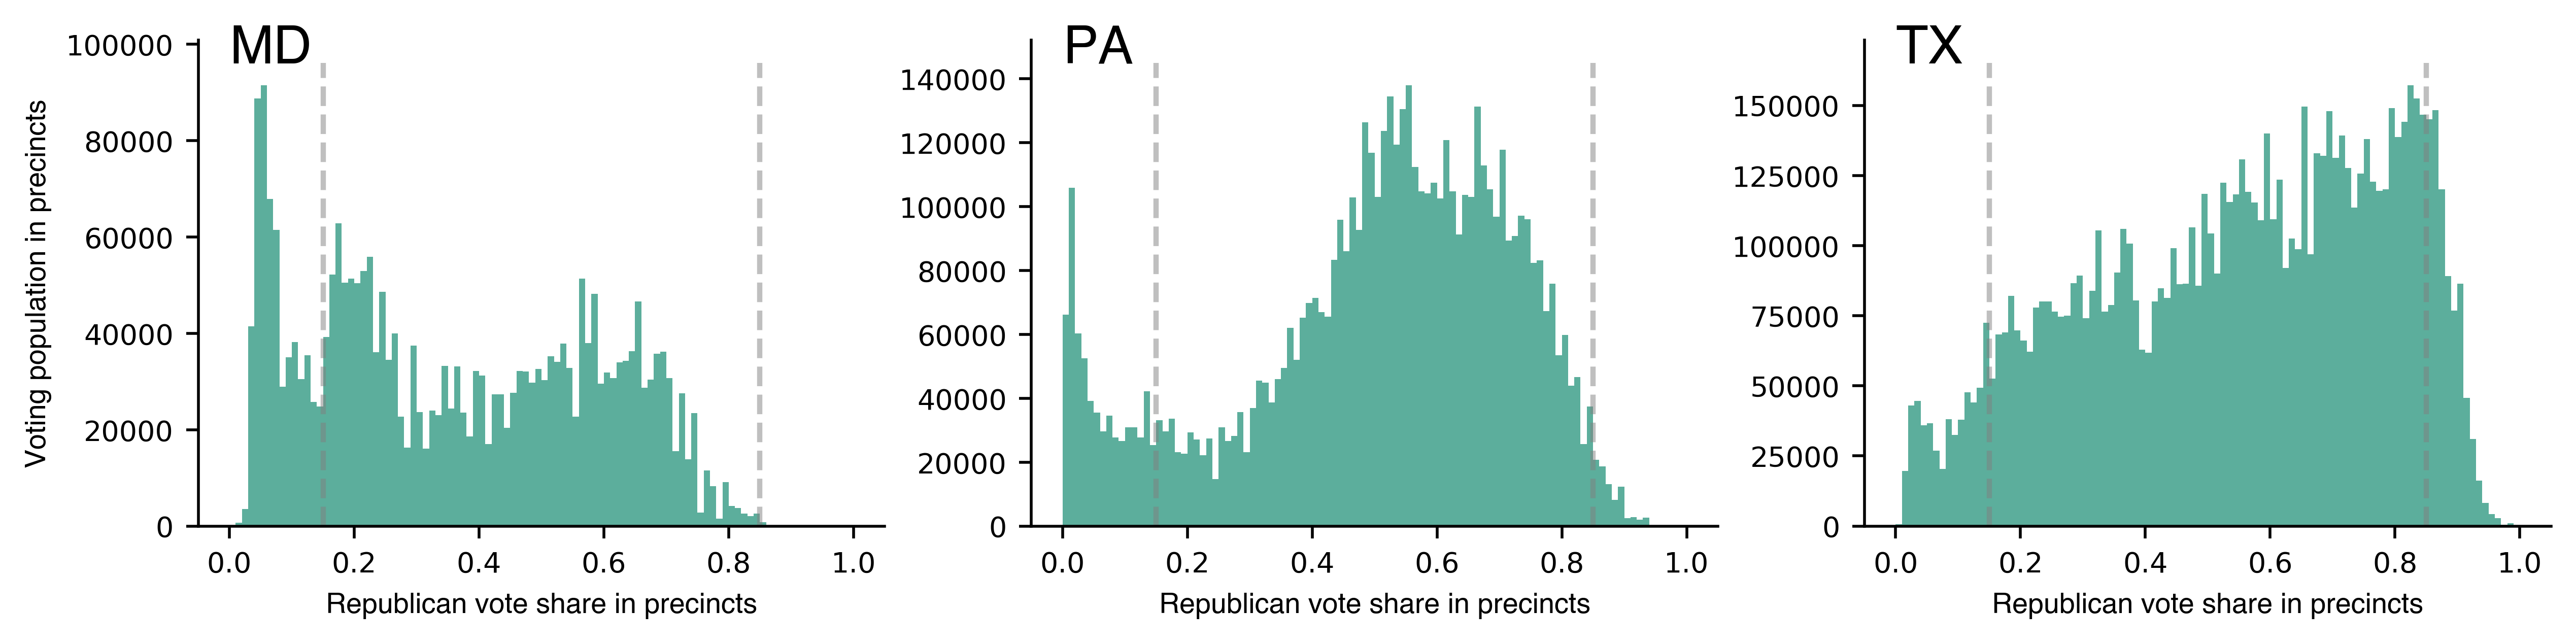

In [145]:
# Plot all three states next to each other, with lines at 15% and 85% Republican vote share. 

plot_histogram_row(["MD", "PA", "TX"])

## What am I looking at?

These cells take all the precincts in the state, and, for each precinct, calculate what percentage of voters in that precinct voted for the Republican Presidential candidate in 2016. The histograms show the total number of people living in the precincts in each bin of Republican vote share. 

A couple things to note:
- In Maryland, there's a clear asymmetry. There are lots of places where the Republican vote share is near zero, and  no places where the Republican vote share is above 85%. 


- Pennsylvania is similar to Maryland at the extremes, but there's an asymmetry from 0.2 to 0.8 as well.

- In Texas, you see the same asymmetry, but only at the far edges of the histogram. While there are almost no precincts at 95% Republican vote share or above, there are many above 85% and 80% Republican vote share. 

We can get a better idea of exactly how many people live in precincts at different Republican vote shares by printing the total population in a vote share range. 

In [146]:
# Define a helper function and print the populations below 15% and above 85% Republican vote share

def print_population_in_range(state,lower_bound,upper_bound):
    print('There are {} people living in precincts in {} where the Republican vote share is between {} and {}\n'.format(int(get_population_in_range_for_state(state,lower_bound,upper_bound)),state,lower_bound, upper_bound))

state = 'MD'
print_population_in_range(state, 0, 0.15)
print_population_in_range(state, 0.85, 1.0)


['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 573797 people living in precincts in MD where the Republican vote share is between 0 and 0.15

['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 930 people living in precincts in MD where the Republican vote share is between 0.85 and 1.0



In [147]:
state = 'TX'
print_population_in_range(state, 0, 0.15)
print_population_in_range(state, 0.85, 1.0)

state = 'TX'
print_population_in_range(state, 0, 0.2)
print_population_in_range(state, 0.8, 1.0)


['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 549600 people living in precincts in TX where the Republican vote share is between 0 and 0.15

['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 775597 people living in precincts in TX where the Republican vote share is between 0.85 and 1.0

['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 891398 people living in precincts in TX where the Republican vote share is between 0 and 0.2

['PRES16R', 'N', 9, 0]
['PRES16D', 'N', 9, 0]
There are 1514589 people living in precincts in TX where the Republican vote share is between 0.8 and 1.0



In [148]:
state = 'GA'
print_population_in_range(state, 0, 0.15)
print_population_in_range(state, 0.85, 1.0)

state = 'GA'
print_population_in_range(state, 0, 0.2)
print_population_in_range(state, 0.8, 1.0)


['PRES16R', 'C', 80, 0]
['PRES16D', 'C', 80, 0]
There are 555051 people living in precincts in GA where the Republican vote share is between 0 and 0.15

['PRES16R', 'C', 80, 0]
['PRES16D', 'C', 80, 0]
There are 311544 people living in precincts in GA where the Republican vote share is between 0.85 and 1.0

['PRES16R', 'C', 80, 0]
['PRES16D', 'C', 80, 0]
There are 673731 people living in precincts in GA where the Republican vote share is between 0 and 0.2

['PRES16R', 'C', 80, 0]
['PRES16D', 'C', 80, 0]
There are 673380 people living in precincts in GA where the Republican vote share is between 0.8 and 1.0

